In [162]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# National Centers for Environmental Information - NOAA
# This script extracts wind speed and direction to generate windrose plots
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Jimmy-Y.Zhang@arup.com
# August 4th, 2022
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Inputs*: 
#         station_name - location/name of weather station
#         date_range   - date range of available data
#         station_ID   - numeric ID of the weather station
#         start_year   - earliest year data is available for station
#         end_year     - most recent year of data available for station
#
#        *input values can be searched and gathered at:
#         https://www.ncei.noaa.gov/access/search/data-search/global-hourly
#
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Output: 
#         Windrose Plot
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
!pip install windrose
import pandas as pd 
import numpy as np 
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from windrose import WindroseAxes
from matplotlib import colors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
# USER INPUT PANE
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Pendleton Station = PENDLETON E OR REGIONAL AIRPORT, OR US; 72688024155; 1942-01-01 to 2022-08-02
# Arlington Station = nearest station@ HERMISTON MUNICIPAL AIRPORT, OR US; 72688304113; 2006-01-01 to 2022-08-02
station_name = 'ARLINGTON MUNI AIRPORT, OR US'
date_range = '2006-01-01 to 2022-08-02'
station_ID = 72688304113
start_year = 2006
end_year = 2022

In [178]:
# Function for sending/receiving/processing API request
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def readAPI(URL):
  
    df = pd.read_csv(URL, parse_dates=["DATE"], low_memory=False)
    df.index = df.DATE
    df = df.resample("H").first()
    df = df[['WND']].copy()
    df['Date'] = df.index
    df[['WindDirStr','A','B','WindSpeedStr','D']] = df.WND.str.split(',', expand=True)
    df['WindDir'] = pd.to_numeric(df['WindDirStr'])
    df['WindSpeed'] = pd.to_numeric(df['WindSpeedStr'])/10
    df = df.drop(['A','B','D','WindSpeedStr','WindDirStr','WND'],axis=1)
    df.reindex(['Date','WindDir','WindSpeed'])
    df = df[df.WindSpeed < 999]
    df_still = df[df.WindSpeed == 0]
    df_windy = df[df.WindSpeed > 0]
    df_windy = df_windy[df_windy.WindDir < 999]

    return df_windy

In [179]:
# Function for plotting windrose
# Adapted from Jinal.Mehta@arup.com & Luca.Amerio@arup.com
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def pltWindrose(station_name, date_range, df_windy):

    ax = WindroseAxes.from_ax()
    ax.set_title('WIND-ROSE PLOT OF\n' + station_name + '\n' + date_range)
    hist = ax.bar(df_windy.WindDir, df_windy.WindSpeed*2.237, normed=True, opening=0.8, edgecolor='white', bins=[2, 4, 8, 12, 16], cmap=cm.rainbow)
    ax.set_legend()
    ax.legend(title='Wind Speed [mph]')

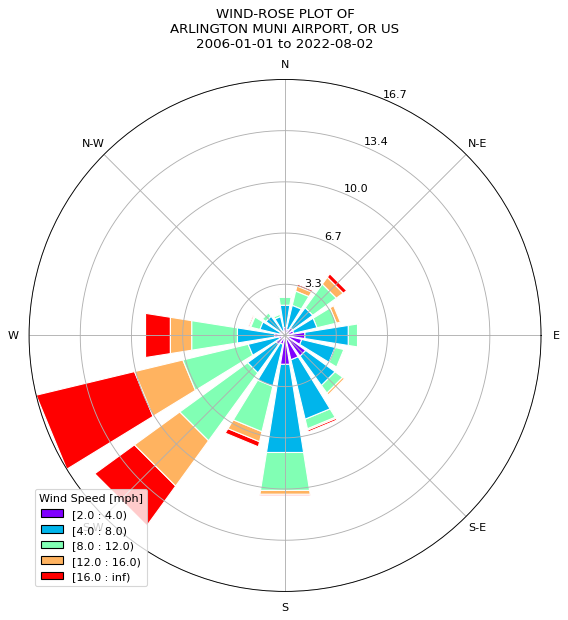

In [180]:
# MAIN
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Initiate
URL = 'https://www.ncei.noaa.gov/data/global-hourly/access/' + str(start_year) + '/' + str(station_ID) + '.csv'
df = readAPI(URL)

# Loop remaining years + append dataframe
for i in range(2,end_year-start_year+2):
    URL = 'https://www.ncei.noaa.gov/data/global-hourly/access/' + str(start_year+i-1) + '/' + str(station_ID) + '.csv'
    try:
        df = df.append(readAPI(URL), ignore_index = True, low_memory=False)
    except:
        continue

# Plot windrose
pltWindrose(station_name, date_range, df)